# Homework 4 Part 4 - Advanced Generation Decoding

## Course Name: Large Language Models
#### Lecturers: Dr. Soleimani, Dr. Rohban, Dr. Asgari

---

#### Notebooks Supervised By: MohammadAli SadraeiJavaheri
#### Notebooks Prepared By: Ali Razghandi, Mahdi Zakizadeh, Faridoun Mehri

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.
- After completing the exercises, save the notebook and <font color='red'>follow the submission guidelines provided in the PDF.</font>


---


## **Name: Javad Razi**

## **Std No: 401204354**

1.  Overview

    In this practical exercise, you will explore different sampling techniques used in natural language generation with pre-trained language models. You will use the `transformers` library to work with a GPT-2 model and apply greedy search, beam search, top-k sampling, and nucleus sampling to generate text. You will also visualize the text generation process and the probabilities of different choices using graphs.

2.  Objectives

    -   Understand and implement the greedy search technique for text generation.
    -   Learn about and apply beam search and visualize the search space.
    -   Explore the concepts of top-k and nucleus sampling as alternative generation strategies.
    -   Visualize the probability distributions of the generated tokens.
    -   Compare the different sampling techniques and their outputs.

3.  Instructions

    1.  **Initial Setup** Fill in your name and student ID at the top of the document. Run the initial code block to install necessary libraries and set up the environment.

    2.  **Greedy Search** Begin by implementing the greedy search algorithm. You will need to complete the function `greedy_search` that generates text by selecting the most likely next token at each step. Your task includes getting the logits, converting token IDs to strings, and adding nodes and edges to the graph.

    3.  **Visualizing the Search** Use the provided code to visualize the greedy search process. The graph will show the probability of each token chosen at every step.

    4.  **Beam Search** Implement the beam search algorithm where you will keep track of multiple hypotheses at each step. You will need to complete the `beam_search` function, which should generate text using a specified number of beams and a chosen sampling strategy.

    5.  **Top-k Sampling** Implement the top-k sampling method within the `top_k_sampling` function. This involves modifying the logits to only consider the top-k most probable tokens and then sampling from this subset. Visualize the probability distribution of the predicted tokens after applying top-k sampling.

    6.  **Nucleus Sampling** Implement nucleus (top-p) sampling in the `nucleus_sampling` function. This technique involves choosing a subset of the vocabulary that has a cumulative probability greater than a threshold `p`, adjusting logits accordingly, and sampling from this subset.

    7.  **Finalizing the Text** For both beam search and sampling strategies, use the provided `get_best_sequence` function to extract the best generated sequence from the leaves of the search graph. Print the generated text.

    8.  **Visualization** After each generation method, plot the graph again to visualize the search space and the probabilities associated with each token in the sequence.

4.  Resources
    -   https://lena-voita.github.io/nlp_course/language_modeling.html#generation_strategies

    Good luck, and remember to have fun exploring the different behaviors of text generation algorithms!

In [17]:
%%capture

# Install transformers and graphviz
!sudo apt-get install graphviz graphviz-dev
!pip install transformers pygraphviz

# Make sure we're using UTF-8 as encoding
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Set seed
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 📚 Background

Complete the `TODO` parts.

In [39]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model.eval()

text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

# Create attention mask
attention_mask = torch.ones(input_ids.shape, device=device)

outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5,
                         pad_token_id=tokenizer.eos_token_id,
                         attention_mask=attention_mask)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Generated text: {generated_text}")

Generated text: I have a dream of being a doctor.


## 🏃‍♂️ Greedy Search

1.  Overview

    In this practical exercise, you will implement a greedy search algorithm to generate text from a given seed using a pre-trained language model. You will be working with the GPT-2 model provided by the `transformers` library. The goal is to understand how greedy search selects the most probable next token at each step and to visualize the generation process using a graph.

2.  Objectives

    -   Implement the greedy search algorithm for text generation.
    -   Visualize the generation process in a graph.
    -   Understand the limitations of greedy search in the context of language generation.

3.  Instructions

    1.  **Greedy Search Implementation** Complete the the missing parts marked with `# TODO`.

In [62]:
def get_log_prob(logits, token_id):
    # TODO: Calculate the log probability of the token_id
    probs = torch.softmax(logits[0, -1, :], dim=-1)
    token_log_probability = torch.log(probs[token_id])
    return token_log_probability.item()

def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    # TODO: Get the predicted logits from the model
    predictions = model(input_ids).logits

    # TODO: Get the predicted next sub-word (here we use greedy search)
    token_id = torch.argmax(predictions[0, -1, :], dim=-1).unsqueeze(0).unsqueeze(0)

    # TODO: Compute the score of the predicted token
    token_score = get_log_prob(predictions, token_id)

    # TODO: Add the predicted token to the list of input ids
    new_input_ids = torch.cat([input_ids, token_id], dim=-1)

    # TODO: Convert token_id to string (skip special tokens, i.e., set None for special tokens)
    next_token = tokenizer.decode(token_id[0]) if token_id[0] not in tokenizer.all_special_ids else None

    # Add node and edge to graph
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # TODO: Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length=length-1)

    return input_ids

# Parameters
length = 5

# Create a balanced tree with height 'length'
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    if node == 0:  # This is the root node
        graph.nodes[node]['tokenscore'] = 100
        graph.nodes[node]['cumscore'] = 0  # Initialize with 0 for the root
        graph.nodes[node]['token'] = text  # Seed text for the root
    else:
        graph.nodes[node]['tokenscore'] = None  # Initialize with None
        graph.nodes[node]['cumscore'] = None  # Initialize with None
        graph.nodes[node]['token'] = None  # Initialize with None

# Start generating text
output_ids = greedy_search(input_ids, 0, length=length)

# TODO: Decode the output_ids to a string, skipping special tokens
output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Generated text: {output}")

Generated text: I have a dream of being a doctor.


The following function visualizes the search tree. It's already complete.

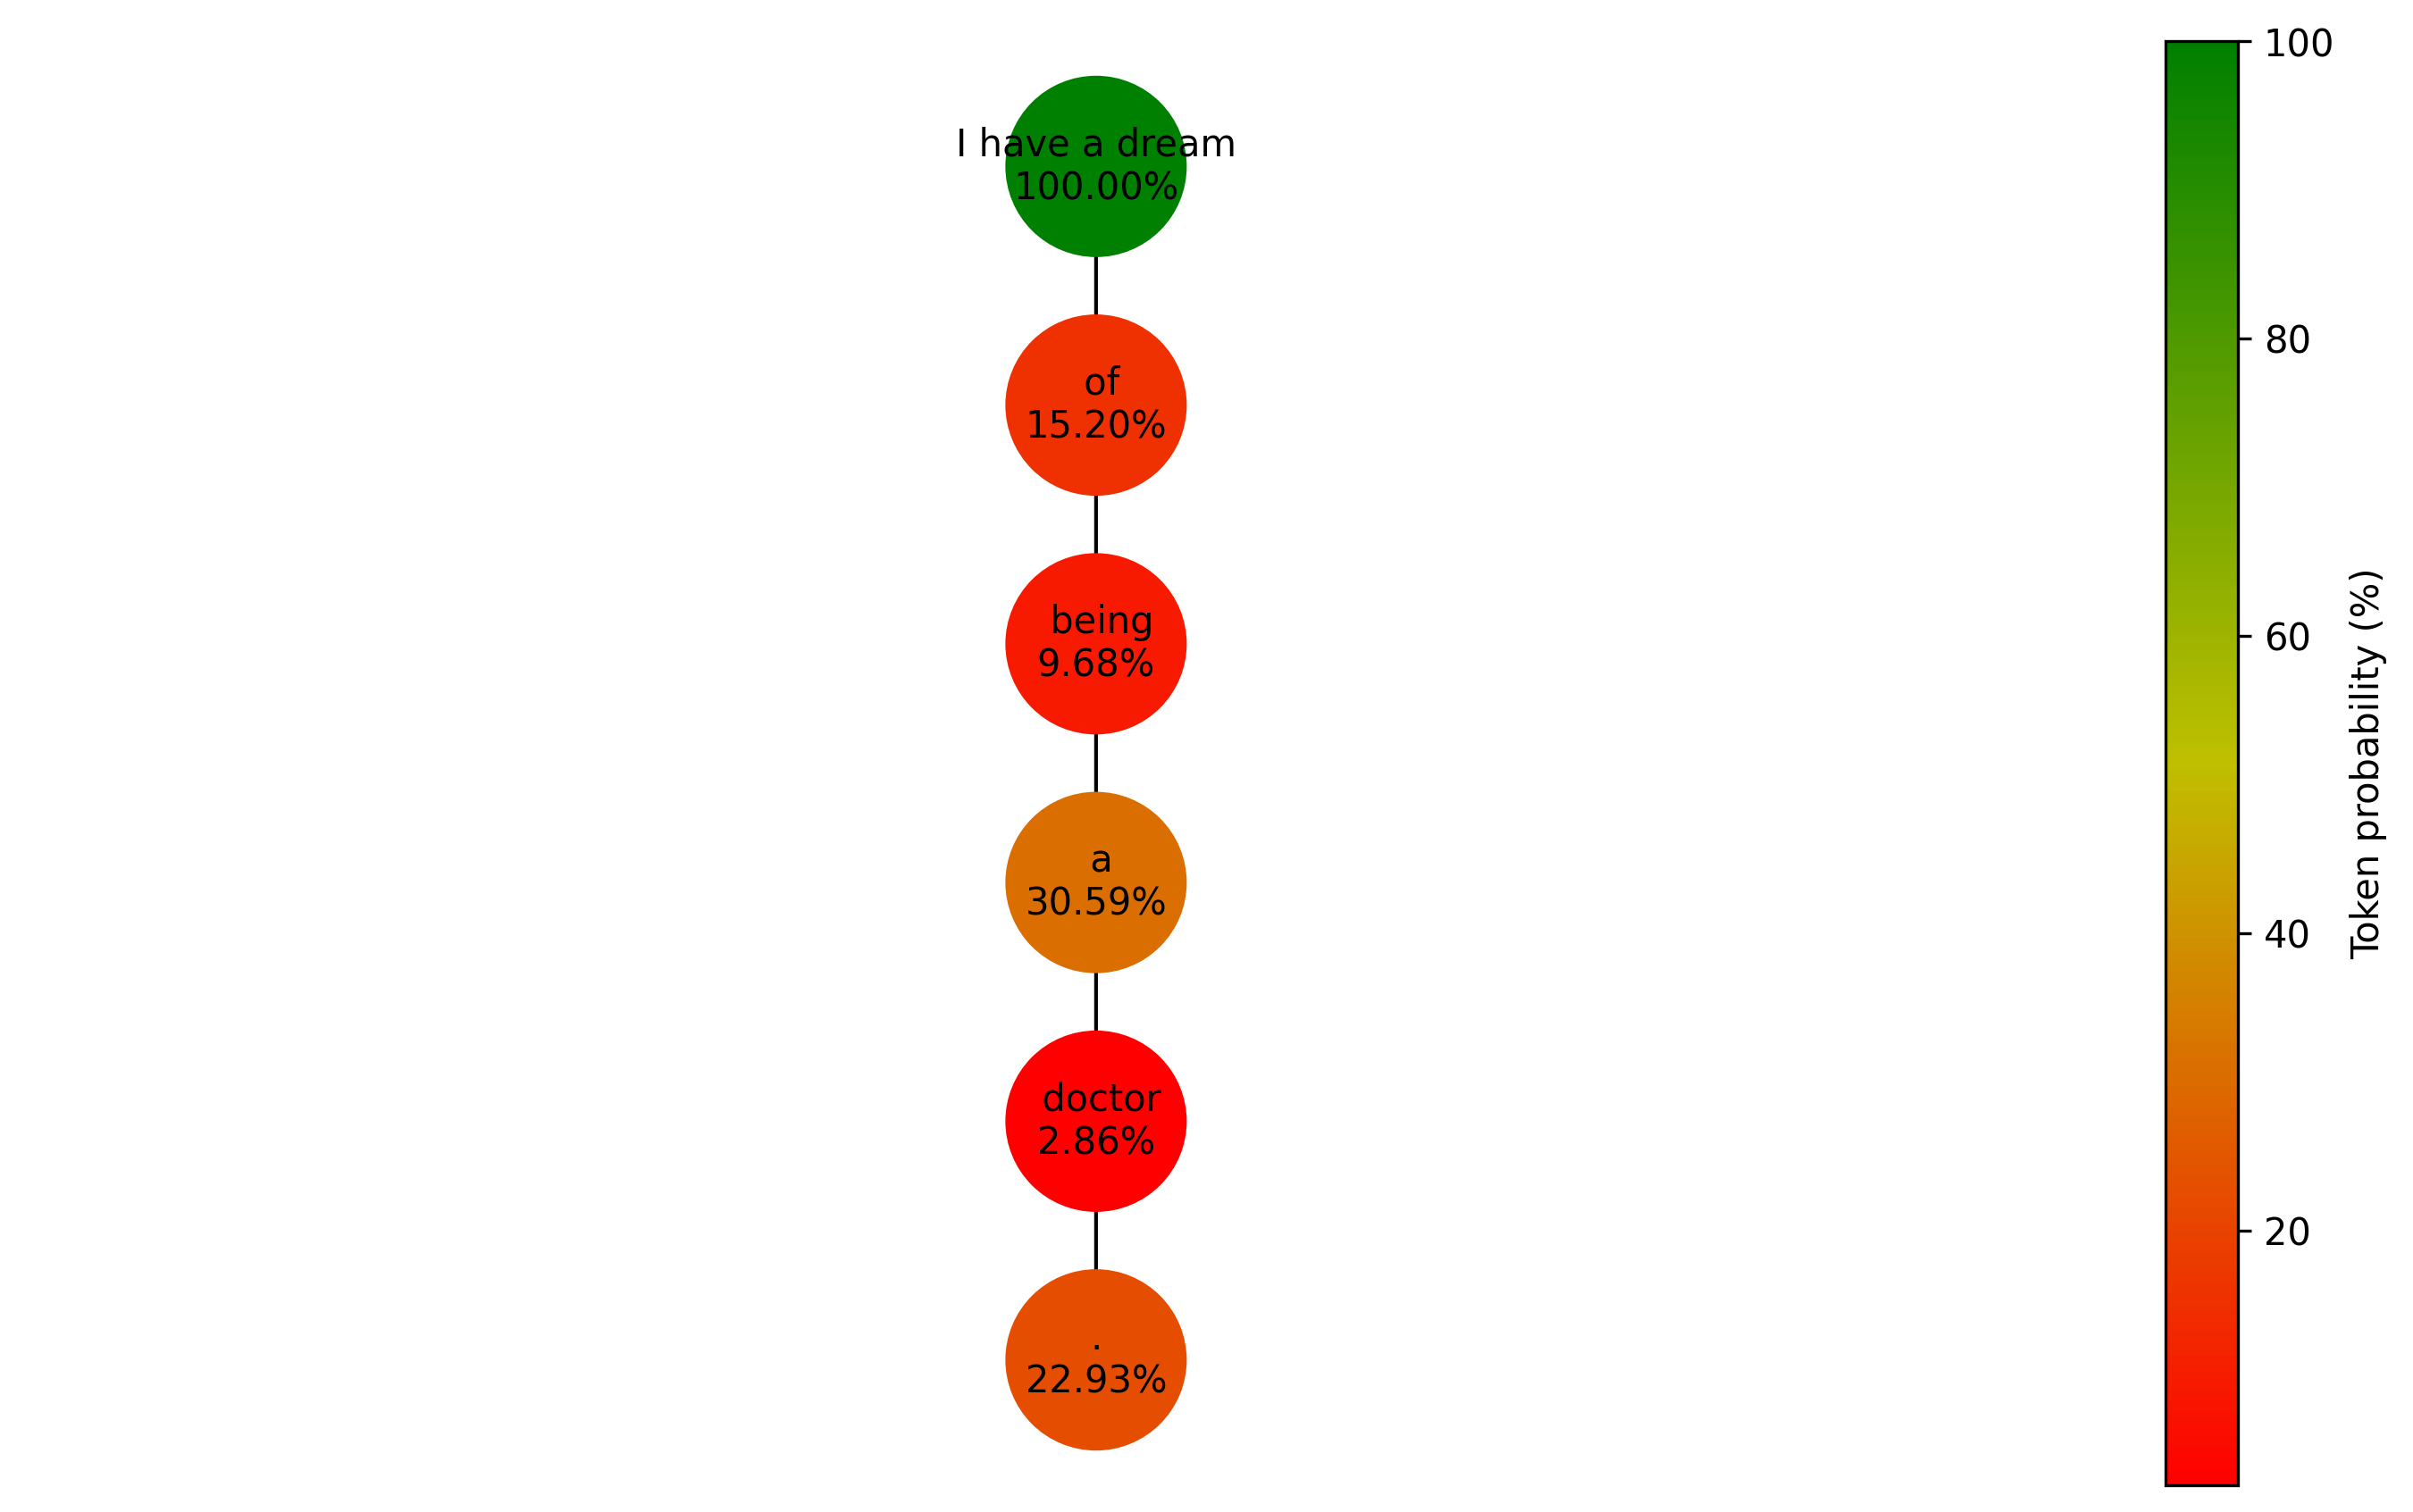

In [63]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalize the colors along the range of token scores
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)

    # Draw the nodes
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4,
                          node_color=scores, cmap=cmap)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

# Plot graph
plot_graph(graph, length, 1.5, 'token')

<div style="color: red;"/>

### Interpretation of Result


***The result is expected given we're using a greedy search algorithm for text generation. This algorithm always selects the most probable next token at each step, which means it doesn't explore multiple paths or branches. Therefore, the search tree of a greedy search is essentially a line, as shown in the generated image.***

## ⚖️ Tree Search (Beam Search)

In this section of the practical exercise, you will delve into tree search, a modified version of beam search, which is a widely used technique for text generation that balances between the breadth and depth of the search space. Unlike the standard beam search that prunes all but the top-k most probable sequences at each step, your implementation will keep all branches, thereby providing a more exhaustive visualization of the search space.

**Key Concepts:**

-   Beam search generates multiple sequences in parallel and keeps track of a fixed number of hypotheses (beams) at each step.
-   It expands each hypothesis by one token and scores them before selecting the top ones to continue the generation process.
-   This modified version of beam search will allow you to see all the possible extensions of each beam, instead of just the best ones.

**Tasks:**

1.  Implement the `greedy_sampling` function to return the top-k token indices based on the logits provided. This will be used when the `sampling` parameter is set to `'greedy'`.

2.  Complete the `beam_search` function by filling in the `TODO` sections. You will need to:

    -   Obtain the next word predictions for the current sequence.
    -   Depending on the `sampling` strategy, use `greedy_sampling`, `top_k_sampling`, or `nucleus_sampling` to determine the next set of tokens to explore.
    -   For each token in the resulting set, compute its score, update the cumulative score, and generate the next step in the sequence.
    -   Add the token to the graph as a new node, along with its associated scores.
    -   Recursively call `beam_search` until the desired sequence length is reached.

3.  Initialize the search graph with attributes for token score, cumulative score, sequence score, and the token itself. The root node will represent the initial text input.

4.  Call the `beam_search` function with the appropriate parameters to begin generating text.

5.  After the search completes, you will use the `get_best_sequence` function (provided in a later part of the exercise) to extract the best-sequence from the search graph.

In [79]:
from tqdm.notebook import tqdm
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

def greedy_sampling(logits, beams):
    # TODO: return top-k indices based on logits provided
    _, topk_indices = torch.topk(logits, beams, dim=-1)
    return topk_indices[0].tolist()

def beam_search(input_ids, node, bar, length, beams, sampling, temperature=1.0):
    if length == 0:
        return None

    # TODO: Get the predicted logits from the model
    predictions = model(input_ids.to(device)).logits
    logits = predictions[:, -1, :] / temperature

    # Get the predicted next sub-word (here we use greedy sampling)
    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        # TODO: Compute the score of the predicted token
        probs = torch.softmax(logits, dim=-1)
        token_score = torch.log(probs[0, token_id]).item()

        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # TODO: Add the predicted token to the list of input ids
        token_id_tensor = torch.tensor([token_id], device=device).unsqueeze(0)
        new_input_ids = torch.cat((input_ids, token_id_tensor), dim=1)

        # TODO: Convert token_id to string (skip special tokens)
        token = tokenizer.decode([token_id], skip_special_tokens=True)

        # Add node and edge to graph
        # Check if current node has fewer children than required
        while len(list(graph.successors(node))) <= j:
            new_node = len(graph.nodes)
            graph.add_node(new_node)
            graph.add_edge(node, new_node)
            graph.nodes[new_node]['tokenscore'] = None
            graph.nodes[new_node]['cumscore'] = None
            graph.nodes[new_node]['sequencescore'] = None
            graph.nodes[new_node]['token'] = None

        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1 / (len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length - 1}_{j}"

        # TODO: Recursive call
        beam_search(new_input_ids, current_node, bar, length - 1, beams, sampling, temperature)

# Parameters
length = 5
beams = 2
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

# Create a balanced tree with height 'length' and branching factor 'beams'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Add 'tokenscore', 'cumscore', 'sequencescore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = None
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = None

# Set the root node's attributes
graph.nodes[0]['tokenscore'] = 100
graph.nodes[0]['cumscore'] = 0
graph.nodes[0]['sequencescore'] = 0
graph.nodes[0]['token'] = text

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)


  0%|          | 0/63 [00:00<?, ?it/s]

Use the get_best_sequence function to extract the best-sequence from the search graph.

In [80]:
def get_best_sequence(G):
    # Create a list of leaf nodes of G
    leaf_nodes = [node for node in G.nodes if G.out_degree(node) == 0 and G.in_degree(node) > 0]

    # Get the leaf node with the highest cumscore (sequencescore)
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['cumscore'] > max_score:
            max_score = G.nodes[node]['cumscore']
            max_score_node = node

    # Retrieve the sequence of nodes from this leaf node to the root node in a list
    path = []
    current_node = max_score_node
    while current_node is not None:
        path.insert(0, current_node)
        # Assumes each node only has one predecessor
        predecessors = list(G.predecessors(current_node))
        current_node = predecessors[0] if predecessors else None

    # Return the string of token attributes of this sequence
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])

    return sequence, max_score

sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I have a dream


**Visualization:**

-   Visualize the search graph after running the `beam_search` function to understand the search process and the distribution of scores across different branches.

You don't need to do anything here.

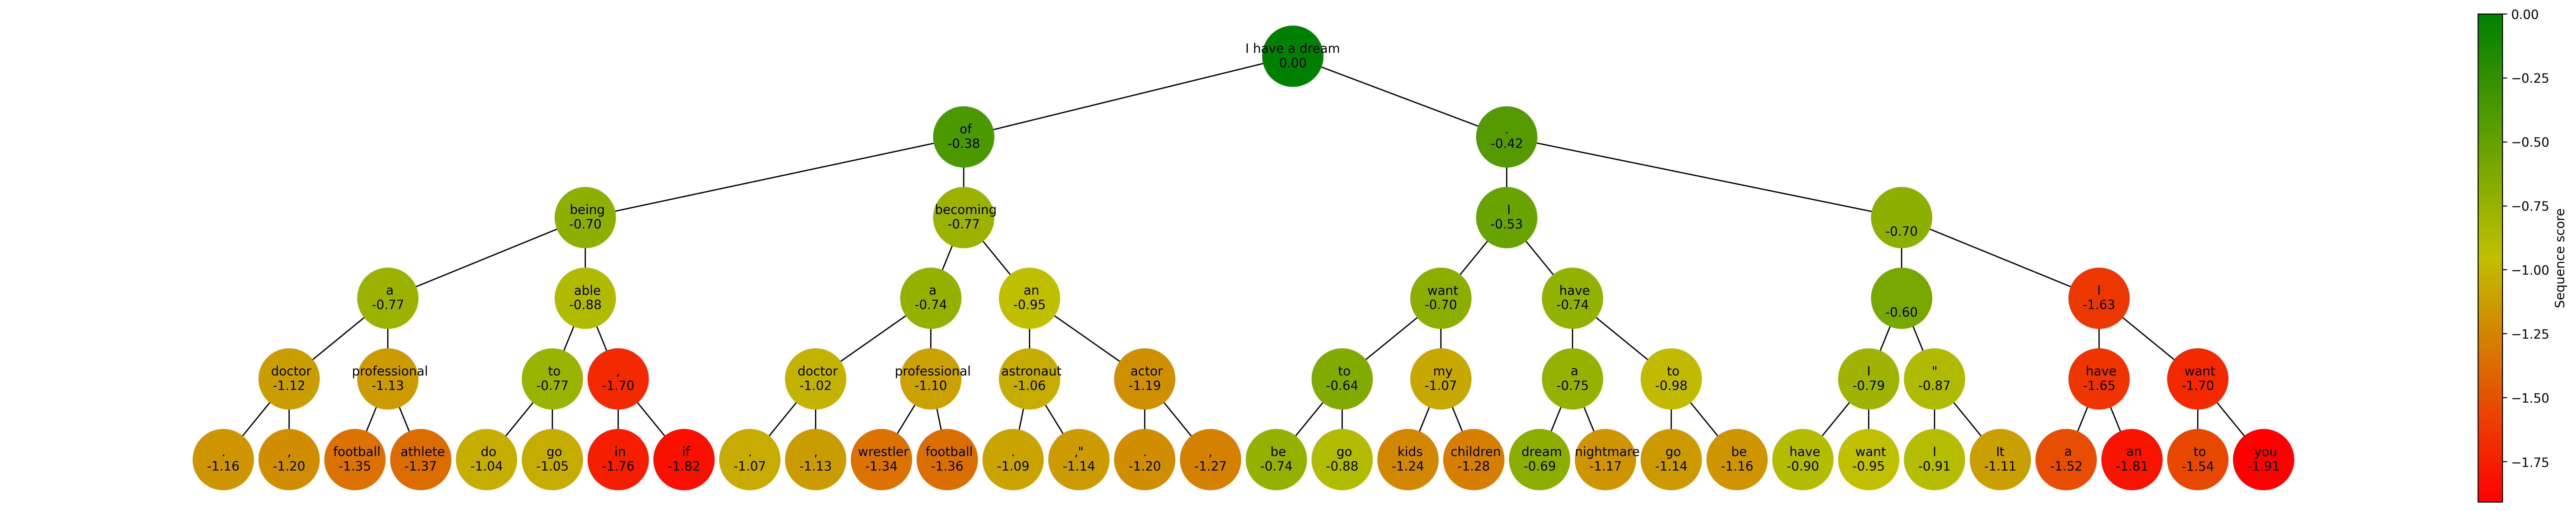

In [81]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

## 🎲 Top-k sampling

In this practical exercise, you will explore top-k sampling, a widely used technique to introduce randomness and diversity into the text generation process. Top-k sampling involves selecting the next token from the top k most likely candidates, as opposed to the single most likely candidate in greedy search or considering all possible candidates. This method can lead to more varied and interesting text generation outcomes.

Objectives

-   Understand the concept of top-k sampling and its application in text generation.
-   Implement the top-k sampling technique using a pre-trained language model.
-   Visualize the probability distribution of the predicted tokens when using top-k sampling.

Instructions

1.  **Top-k Sampling Implementation** Complete the `top_k_sampling` function by filling in the sections marked with `# TODO`.

## DONE

From the next cell, I've done nothing and below cell doesn't run.

In [82]:
def plot_prob_distribution(probabilities, next_tokens, sampling, potential_nb, total_nb=50):
    # Get top k tokens
    top_k_prob, top_k_indices = torch.topk(probabilities, total_nb)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices.tolist()]

    # Get next tokens and their probabilities
    next_tokens_list = [tokenizer.decode([idx]) for idx in next_tokens.tolist()]
    next_token_prob = probabilities[next_tokens].tolist()

    # Create figure
    plt.figure(figsize=(0.4*total_nb, 5), dpi=300, facecolor='white')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    if potential_nb < total_nb:
        plt.axvline(x=potential_nb-0.5, ls=':', color='grey', label='Sampled tokens')
    plt.bar(top_k_tokens, top_k_prob.tolist(), color='blue')
    plt.bar(next_tokens_list, next_token_prob, color='red', label='Selected tokens')
    plt.xticks(rotation=45, ha='right', va='top')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if sampling == 'top_k':
        plt.title('Probability distribution of predicted tokens with top-k sampling')
    elif sampling == 'nucleus':
        plt.title('Probability distribution of predicted tokens with nucleus sampling')
    plt.legend()
    plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)
    plt.close()

import torch
import matplotlib.pyplot as plt
import time

def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    # Remove all tokens with a probability lower than the last token of the top-k
    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = -float('Inf')  # Set to negative infinity

    # Convert new_logits to probabilities (use temperature)
    probabilities = torch.softmax(new_logits / temperature, dim=-1)

    # Sample n=beams tokens from the resulting distribution (without duplicates!)
    next_tokens = torch.multinomial(probabilities, beams, replacement=False)

    # Plot distribution
    if plot:
        # Convert logits to probabilities (use temperature)
        total_prob = torch.softmax(logits / temperature, dim=-1)

        plot_prob_distribution(total_prob, next_tokens, 'top_k', top_k)

    return next_tokens

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'top_k', 1)

UnboundLocalError: local variable 'top_token_ids' referenced before assignment

In [ ]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

In [ ]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

## 🔬 Nucleus sampling

In this practical exercise, you will implement nucleus sampling, also known as top-p sampling, for text generation. Nucleus sampling is a technique that enhances the diversity of the generated text by focusing on a dynamically sized subset of the vocabulary that cumulatively surpasses a specified probability threshold (p). This method is designed to avoid the pitfalls of selecting tokens with extremely low likelihoods while still maintaining variability in the generation process.

Objectives

-   Learn how nucleus sampling selects a subset of the vocabulary based on cumulative probabilities.
-   Implement nucleus sampling and integrate it with a pre-trained language model for text generation.
-   Visualize the impact of nucleus sampling on the probability distribution of tokens.

Instructions

1.  **Nucleus Sampling Implementation** Complete the the sections marked with `# TODO`


You can read about nucleus sampling here: https://nn.labml.ai/sampling/nucleus.html


In [ ]:
def nucleus_sampling(logits, temperature, p, beams, plot=True):
    ##
    assert p > 0
    assert p <= 1

    # Sort the probabilities in descending order and compute cumulative probabilities
    sorted_logits, sorted_indices = # TODO
    probabilities = # TODO sorted_logits to probabilities (use temperature)

    # Create a mask for probabilities that are in the top-p
    mask = # TODO

    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
        # `tolist` returns an scalar if the torch value is a scalar.
    else:
        # This branch should not be needed.
        top_p_index_to_keep = beams

    # Only keep top-p indices
    indices_to_remove = sorted_indices[top_p_index_to_keep:]

    sorted_logits[indices_to_remove] = # TODO

    # Sample n tokens from the resulting distribution (without duplicates!)
    probabilities = # TODO from the new sorted_logits (use temperature)
    next_tokens = # TODO

    # Plot distribution
    if plot:
        total_prob = # TODO from logits
        plot_prob_distribution(total_prob, next_tokens, 'nucleus', top_p_index_to_keep)

    return next_tokens

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'nucleus', 1)

In [ ]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

In [ ]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')